In [2]:
import pandas as pd

yelp_data_path = '/home/dai/33/nlp_cv/data/sentiment+labelled+sentences/sentiment labelled sentences/yelp_labelled.txt'

df = pd.read_csv(yelp_data_path, names=['text', 'label'], sep='\t')
df.head()

,text,label
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


### Splitting the data

In [3]:
from sklearn.model_selection import train_test_split

X = df['text'].values
y = df['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=1000)

### Helper Functions

In [4]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

### Baseline Model (Using ML)

#### Bag of Words

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [26]:
cv = CountVectorizer()

X_train = cv.fit_transform(sentences_train)
X_test = cv.transform(sentences_test)

X_train

<750x1714 sparse matrix of type '<class 'numpy.int64'>'
	with 7368 stored elements in Compressed Sparse Row format>

In [27]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [29]:
y_pred = lr.predict(X_test)
accuracy_score(y_test, y_pred)

0.796

#### Tf-IDF Vectorizer

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

X_train = tfidf.fit_transform(sentences_train)
X_test = tfidf.transform(sentences_test)

lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
accuracy_score(y_test, y_pred)

0.768

### Deep Learning Era

#### Simple Model in Keras

**Text is converted using Bag of Words**

In [36]:
import keras
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import Dense

tfidf = TfidfVectorizer()

X_train = tfidf.fit_transform(sentences_train)
X_test = tfidf.transform(sentences_test)

keras.backend.clear_session()
model = Sequential()

model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train.toarray(), y_train, epochs=100, verbose=1,
                    validation_data=(X_test.toarray(), y_test), batch_size=10)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print(f"Training Accuracy: {accuracy:.4f}")
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print(f"Testing Accuracy:  {accuracy:.4f}")

plot_history(history)

#### Text Vectorization

In [5]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1

In [6]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [7]:
X_train.shape

(750, 100)

#### Simple Model in Keras

**Using Embedding Layer**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           87350     
                                                                 
 flatten (Flatten)           (None, 5000)              0         
                                                                 
 dense (Dense)               (None, 10)                50010     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 137371 (536.61 KB)
Trainable params: 137371 (536.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Training Accuracy: 1.0000
Testing Accuracy:  0.7240


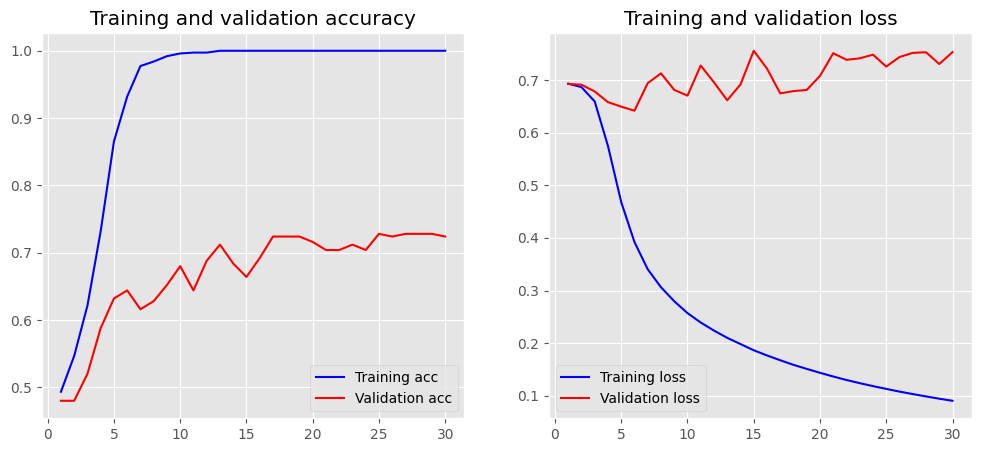

In [7]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding

embeddding_dim = 50

keras.backend.clear_session()
model = Sequential()

model.add(Embedding(input_dim=vocab_size, output_dim=embeddding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=30,
                    verbose=0,
                    batch_size=10)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print(f"Training Accuracy: {accuracy:.4f}")
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print(f"Testing Accuracy:  {accuracy:.4f}")

plot_history(history)

**Using Global Max Pooling 1D**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           87350     
                                                                 
 global_max_pooling1d (Glob  (None, 50)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 87871 (343.25 KB)
Trainable params: 87871 (343.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Training Accuracy: 1.0000
Testing Accuracy:  0.8080


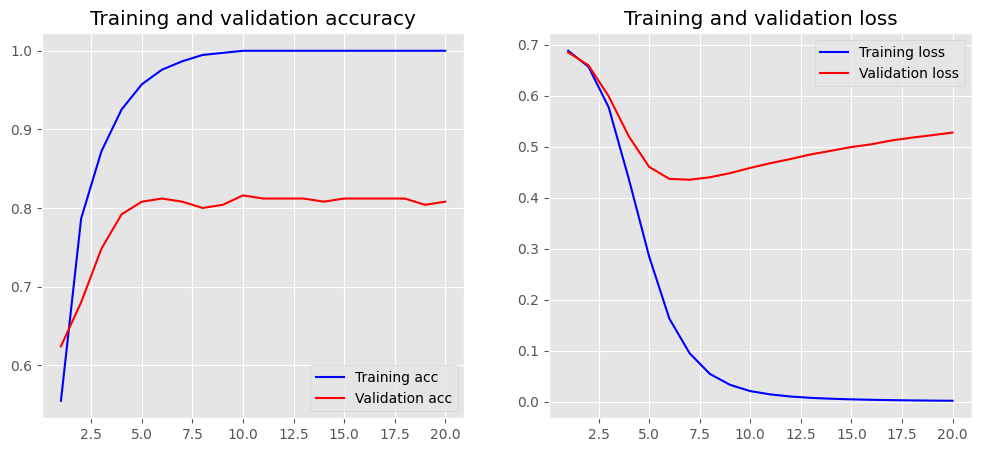

In [8]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, GlobalMaxPooling1D

embeddding_dim = 50

keras.backend.clear_session()
model = Sequential()

model.add(Embedding(input_dim=vocab_size, output_dim=embeddding_dim, input_length=maxlen))
model.add(GlobalMaxPooling1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=20,
                    verbose=0,
                    batch_size=10)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print(f"Training Accuracy: {accuracy:.4f}")
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print(f"Testing Accuracy:  {accuracy:.4f}")

plot_history(history)

In [10]:
text1 = 'Best Service ever! It was great, I will definitely recommend it.'
text2 = 'Very, very sad.'
text3 = 'Amazing... great place.'

def predict_review_phind(review):
   # Preprocess the review
   sequence = tokenizer.texts_to_sequences([review])
   sequence = pad_sequences(sequence, maxlen=maxlen)

   # Get the prediction
   prediction = model.predict(sequence, verbose=0)[0][0]

   # Return the result
   if prediction > 0.5:
       return (prediction, "Positive")
   else:
       return (prediction, "Negative")


predict_review_phind(text3)

(0.21398474, 'Negative')

#### CNN

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          174700    
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 240129 (938.00 KB)
Trainable params: 240129 (938.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________

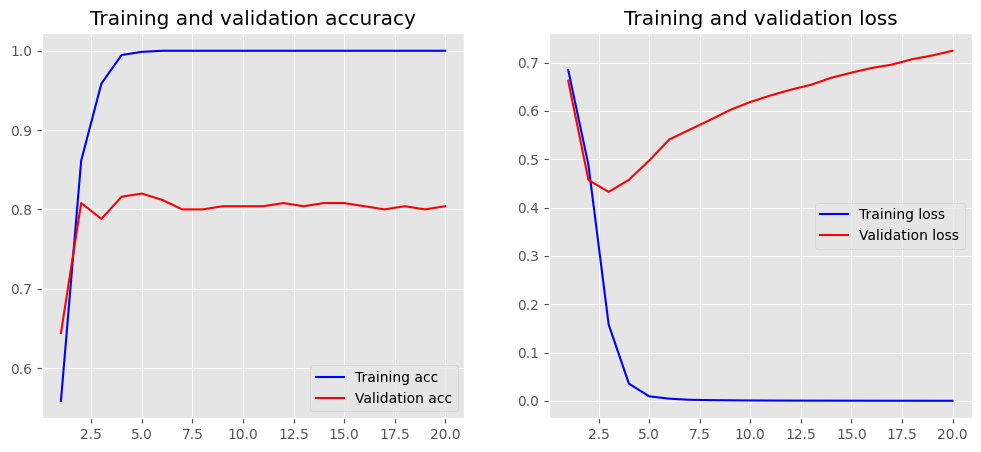

In [9]:
import keras 
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D

embeddding_dim = 100

keras.backend.clear_session()
model = Sequential()

model.add(Embedding(input_dim=vocab_size, output_dim=embeddding_dim, input_length=maxlen))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=20,
                    verbose=1,
                    batch_size=10)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print(f"Training Accuracy: {accuracy:.4f}")
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print(f"Testing Accuracy:  {accuracy:.4f}")

plot_history(history)

In [15]:
text1 = 'Best Service ever! It was great, I will definitely recommend it.'
text2 = 'Worst martini ever'
text3 = 'Amazing... great place.'

def predict_review_phind(review):
   # Preprocess the review
   sequence = tokenizer.texts_to_sequences([review])
   sequence = pad_sequences(sequence, maxlen=maxlen)

   # Get the prediction
   prediction = model.predict(sequence, verbose=0)[0][0]

   # Return the result
   if prediction > 0.5:
       return (prediction, "Positive")
   else:
       return (prediction, "Negative")


predict_review_phind(text2)

(0.20010868, 'Negative')